## <b> Transformer NMT (English → French) Experiment </b>

이번 복습과제에서는 Transformer Encoder–Decoder 구조를 직접 구현하여 영어 문장을 프랑스어로 번역하는 실험을 진행합니다.

- ManyThings(Anki) 공개 번역 데이터를 활용하여, 데이터 정제 → 토크나이징 → 패딩 → 모델 학습 → 추론까지 전 과정을 포함하고 있습니다.

- Positional Encoding, Padding Mask, Look-Ahead Mask, Multi-Head Attention, Feed-Forward Network 등 Transformer의 핵심 구성요소를 코드로 확인합니다.

- Teacher Forcing 기반 학습을 통해, 디코더가 다음 단어를 예측하도록 학습되는 과정을 관찰합니다.

- 학습된 모델로 임의의 영어 문장을 입력해 Autoregressive 방식으로 번역을 생성해봅니다.

- 중간 출력(텐서 shape, 토큰 id, 마스크 형태 등)을 확인하며, Transformer 내부 흐름을 이해하는 데 초점을 둡니다.

In [1]:
#1 Imports + Seed + Utils
import os
import torch.optim as optim
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm, tqdm_notebook, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import unicodedata
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import urllib3
import zipfile
import shutil
import pandas as pd

pd.set_option('display.max_colwidth', None)

# 시드 고정
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ENCODER_LEN = 40  # 입력·출력 문장 토큰 길이를 40으로 고정
DECODER_LEN = ENCODER_LEN
BATCH_SIZE  = 128 # 한 step에서 학습하는 문장쌍 개수
N_EPOCHS = 20 # 전체 데이터셋을 반복 학습하는 횟수 (*로컬 환경에서는 모델 학습에 장시간 소요되므로, 줄이는 것을 추천!)

# 디버깅 함수
def show_shape(name, x):
    if isinstance(x, torch.Tensor):
        print(f"{name}: shape={tuple(x.shape)}, dtype={x.dtype}, device={x.device}")
    else:
        print(f"{name}: type={type(x)}")

def show_tokens(tokenizer, seq, n=20):
    seq = list(seq)
    print("ids   :", seq[:n])
    print("text  :", tokenizer.sequences_to_texts([seq[:n]])[0])

def count_pad(x, pad_id=0):
    return int((x == pad_id).sum().item()), x.numel()

DEBUG_ONCE = {"attn": True}

In [2]:
#2 번역 데이터셋 다운로드 및 로드 (English-French Parallel Corpus)
!rm -f fra-eng.zip fra.txt
!wget -q https://www.manythings.org/anki/fra-eng.zip
!unzip -q fra-eng.zip

import pandas as pd

train_df = pd.read_csv('fra.txt', names=['SRC', 'TRG', 'lic'], sep='\t')
del train_df['lic']

print("영어-프랑스어 번역 쌍 총 개수:", len(train_df))
train_df = train_df.loc[:, 'SRC':'TRG']
train_df.head()

영어-프랑스어 번역 쌍 총 개수: 239189


,SRC,TRG
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [3]:
# Length stats + Dedup + Filter + Sample

train_df["src_len"] = train_df["SRC"].astype(str).str.split().str.len()
train_df["trg_len"] = train_df["TRG"].astype(str).str.split().str.len()

print('Translation Pair :', len(train_df))

train_df = train_df.drop_duplicates(subset=["SRC"])
print('After SRC dedup :', len(train_df))

train_df = train_df.drop_duplicates(subset=["TRG"])
print('After TRG dedup :', len(train_df))

is_within_len = (
    (8 < train_df["src_len"]) & (train_df["src_len"] < 20) &
    (8 < train_df["trg_len"]) & (train_df["trg_len"] < 20)
)
train_df = train_df[is_within_len]

dataset_df_8096 = train_df.sample(n=1024*8, random_state=1234)
print('Sampled Pair :', len(dataset_df_8096))

Translation Pair : 239189
After SRC dedup : 171971
After TRG dedup : 153441
Sampled Pair : 8192


In [4]:
# Preprocess (raw_src/raw_trg) + Sanity Print
raw_src = []
for sentence in dataset_df_8096['SRC']:
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)

    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    raw_src.append(sentence)

raw_trg = []
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

for sentence in dataset_df_8096['TRG']:
    sentence = unicode_to_ascii(sentence.lower())
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)
    sentence = re.sub(r"\s+", " ", sentence)
    raw_trg.append(sentence)

print("=== Preprocess sanity check (top-3) ===")
for i in [0, 1, 2]:
    print(f"\n[{i}] SRC_raw :", dataset_df_8096['SRC'].iloc[i])
    print(f"[{i}] SRC_clean:", raw_src[i])
    print(f"[{i}] TRG_raw :", dataset_df_8096['TRG'].iloc[i])
    print(f"[{i}] TRG_clean:", raw_trg[i])

=== Preprocess sanity check (top-3) ===

[0] SRC_raw : Was there a dead body in the room? "No, there was no body there."
[0] SRC_clean: was there a dead body in the room ? no , there was no body there .
[0] TRG_raw : « Y avait-il un cadavre dans la chambre ? » « Non, il n'y avait pas de cadavre. »
[0] TRG_clean:  y avait il un cadavre dans la chambre ? non il n y avait pas de cadavre . 

[1] SRC_raw : Our teacher doesn't just speak English, but French too.
[1] SRC_clean: our teacher does not just speak english , but french too .
[1] TRG_raw : Notre professeur ne parle pas juste anglais mais aussi français.
[1] TRG_clean: notre professeur ne parle pas juste anglais mais aussi francais .

[2] SRC_raw : I don't know whether he is dead or alive.
[2] SRC_clean: i do not know whether he is dead or alive .
[2] TRG_raw : Je ne sais pas s'il est mort ou vivant.
[2] TRG_clean: je ne sais pas s il est mort ou vivant .


### Q1. <SOS>/<EOS> 토큰의 역할
이 코드에서는 입력/출력 문장에 `<SOS>`, `<EOS>` 토큰을 직접 붙였습니다.

1) `<SOS>`와 `<EOS>`는 각각 언제/왜 필요한가요?  
`<SOS>`와 `<EOS>` 토큰은 문장의 시작과 끝을 모델이 명확하게 인식하도록 하기 위해 사용된다. `<SOS>`는 문장 생성의 시작을 알리는 토큰으로, 디코더가 첫 단어를 예측할 때 초기 입력으로 사용된다. 반면 `<EOS>`는 문장의 종료를 의미하는 토큰으로, 모델이 `<EOS>`를 예측하면 더 이상 단어를 생성하지 않고 문장 생성을 멈추도록 한다.

In [5]:
# Build train_df + Add SOS/EOS + Tokenizer + Vocab Print
df1 = pd.DataFrame(raw_src)
df2 = pd.DataFrame(raw_trg)
df1.rename(columns={0: "SRC"}, errors="raise", inplace=True)
df2.rename(columns={0: "TRG"}, errors="raise", inplace=True)
train_df = pd.concat([df1, df2], axis=1)
print('Translation Pair :',len(train_df))

raw_src  = train_df['SRC']
raw_trg  = train_df['TRG']

src_sentence  = raw_src.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
trg_sentence  = raw_trg.apply(lambda x: "<SOS> "+ x + " <EOS>")

print("=== SOS/EOS check ===")
print("SRC example:", src_sentence.iloc[0])
print("TRG example:", trg_sentence.iloc[0])

filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

SRC_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
TRG_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

SRC_tokenizer.fit_on_texts(src_sentence)
TRG_tokenizer.fit_on_texts(trg_sentence)

n_enc_vocab = len(SRC_tokenizer.word_index) + 1
n_dec_vocab = len(TRG_tokenizer.word_index) + 1

print('Encoder vocab size :', n_enc_vocab)
print('Decoder vocab size :', n_dec_vocab)

print("\n=== Tokenizer vocab check ===")
print("SRC '<sos>' id:", SRC_tokenizer.word_index.get("<sos>"))
print("SRC '<eos>' id:", SRC_tokenizer.word_index.get("<eos>"))
print("TRG '<sos>' id:", TRG_tokenizer.word_index.get("<sos>"))
print("TRG '<eos>' id:", TRG_tokenizer.word_index.get("<eos>"))
print("TRG '<unk>' id:", TRG_tokenizer.word_index.get("<unk>"))

print("\nSRC top-10:", list(SRC_tokenizer.word_index.items())[:10])
print("TRG top-10:", list(TRG_tokenizer.word_index.items())[:10])


Translation Pair : 8192
=== SOS/EOS check ===
SRC example: <SOS> was there a dead body in the room ? no , there was no body there . <EOS>
TRG example: <SOS>  y avait il un cadavre dans la chambre ? non il n y avait pas de cadavre .  <EOS>
Encoder vocab size : 5924
Decoder vocab size : 7773

=== Tokenizer vocab check ===
SRC '<sos>' id: 2
SRC '<eos>' id: 3
TRG '<sos>' id: 2
TRG '<eos>' id: 3
TRG '<unk>' id: 1

SRC top-10: [('<unk>', 1), ('<sos>', 2), ('<eos>', 3), ('the', 4), ('to', 5), ('i', 6), ('you', 7), ('a', 8), ('not', 9), ('is', 10)]
TRG top-10: [('<unk>', 1), ('<sos>', 2), ('<eos>', 3), ('de', 4), ('a', 5), ('je', 6), ('que', 7), ('la', 8), ('le', 9), ('pas', 10)]


In [6]:
# Tokenization Demo + Pad + Decode Check
lines = [
  "It is winter and the weather is very cold.",
  "Will this Christmas be a white Christmas?",
  "Be careful not to catch a cold in winter and have a happy new year."
]
print("=== SRC tokenizer demo ===")
for line in lines:
    txt_2_ids = SRC_tokenizer.texts_to_sequences([line])
    ids_2_txt = SRC_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input     :", line)
    print("txt_2_ids :", txt_2_ids)
    print("ids_2_txt :", ids_2_txt[0],"\n")

lines = [
  "C'est l'hiver et il fait très froid.",
  "Ce Noël sera-t-il un Noël blanc ?",
  "Attention à ne pas attraper froid en hiver et bonne année."
]
print("=== TRG tokenizer demo ===")
for line in lines:
    txt_2_ids = TRG_tokenizer.texts_to_sequences([line])
    ids_2_txt = TRG_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input     :", line)
    print("txt_2_ids :", txt_2_ids)
    print("ids_2_txt :", ids_2_txt[0],"\n")

tokenized_inputs  = SRC_tokenizer.texts_to_sequences(src_sentence)
tokenized_outputs = TRG_tokenizer.texts_to_sequences(trg_sentence)

tkn_sources = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_inputs, maxlen=ENCODER_LEN, padding='post', truncating='post'
)
tkn_targets = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_outputs, maxlen=DECODER_LEN, padding='post', truncating='post'
)

print("=== Padding check ===")
print("tkn_sources[0][:30]:", tkn_sources[0][:30])
print("tkn_targets[0][:30]:", tkn_targets[0][:30])

print("\nSRC decoded (first 30):")
show_tokens(SRC_tokenizer, tkn_sources[0], n=30)
print("TRG decoded (first 30):")
show_tokens(TRG_tokenizer, tkn_targets[0], n=30)

=== SRC tokenizer demo ===
Input     : It is winter and the weather is very cold.
txt_2_ids : [[15, 10, 926, 23, 4, 458, 10, 96, 304]]
ids_2_txt : it is winter and the weather is very cold 

Input     : Will this Christmas be a white Christmas?
txt_2_ids : [[28, 25, 138, 26, 8, 466, 138]]
ids_2_txt : will this christmas be a white christmas 

Input     : Be careful not to catch a cold in winter and have a happy new year.
txt_2_ids : [[26, 575, 9, 5, 372, 8, 304, 14, 926, 23, 17, 8, 319, 110, 179]]
ids_2_txt : be careful not to catch a cold in winter and have a happy new year 

=== TRG tokenizer demo ===
Input     : C'est l'hiver et il fait très froid.
txt_2_ids : [[1, 1, 30, 11, 55, 1, 451]]
ids_2_txt : <unk> <unk> et il fait <unk> froid 

Input     : Ce Noël sera-t-il un Noël blanc ?
txt_2_ids : [[17, 1, 245, 70, 11, 14, 1, 691]]
ids_2_txt : ce <unk> sera t il un <unk> blanc 

Input     : Attention à ne pas attraper froid en hiver et bonne année.
txt_2_ids : [[740, 1, 13, 10, 666, 451

In [7]:
# Torch tensors + DataLoader + Batch Shape Check
tensors_src = torch.tensor(tkn_sources).to(device)
tensors_trg = torch.tensor(tkn_targets).to(device)

from torch.utils.data import TensorDataset, DataLoader

dataset    = TensorDataset(tensors_src, tensors_trg)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print("=== One batch shape check ===")
src_batch, trg_batch = next(iter(dataloader))
show_shape("src_batch", src_batch)
show_shape("trg_batch", trg_batch)
pad_cnt, total = count_pad(src_batch, pad_id=0)
print(f"SRC PAD ratio: {pad_cnt}/{total} = {pad_cnt/total:.3f}")

=== One batch shape check ===
src_batch: shape=(128, 40), dtype=torch.int32, device=cpu
trg_batch: shape=(128, 40), dtype=torch.int32, device=cpu
SRC PAD ratio: 3415/5120 = 0.667


### Q2. Positional Encoding

1) Positional Encoding을 하는 이유가 무엇인가요?  
Transformer는 RNN과 달리 단어를 순차적으로 처리하지 않고 동시에 처리하기 때문에 단어의 순서 정보가 반영되지 않는다. 따라서 각 단어의 위치 정보를 모델에 전달하기 위해 Positional Encoding을 추가한다.

In [8]:
# Hyperparams + Positional Encoding + Mask Functions + Mask Debug
n_layers  = 2
hid_dim   = 256
pf_dim    = 1024
n_heads   = 8
dropout   = 0.3
pe_source = 512
pe_target = 512
layer_norm_epsilon = 1e-12

class get_sinusoid_encoding_table(nn.Module):
    def __init__(self, position, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        pe = torch.zeros(position, hid_dim).to(device)

        for pos in range(position):
            for i in range(0, hid_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/hid_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i)/hid_dim)))

        self.pe = pe.unsqueeze(0)
        self.pe.requires_grad = False

    def forward(self, x):
        ret = math.sqrt(self.hid_dim)*x + self.pe[:, :x.size(1)]
        return ret

def create_padding_mask(x):
    input_pad = 0
    mask = (x == input_pad).float()
    mask = mask.unsqueeze(1).unsqueeze(1)
    return mask

def create_look_ahead_mask(seq):
    seq_len = seq.shape[1]
    look_ahead_mask = torch.ones(seq_len, seq_len)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1).to(device)
    return look_ahead_mask

print("=== Positional Encoding sanity ===")
x = torch.zeros(2, 5, hid_dim).to(device)
pe = get_sinusoid_encoding_table(10, hid_dim).to(device)
y = pe(x)
show_shape("x", x)
show_shape("y", y)
print("y[0,0,0:6] =", y[0,0,:6].detach().cpu().numpy())
print("y[0,1,0:6] =", y[0,1,:6].detach().cpu().numpy(), "(different position)")

print("\n=== Mask check ===")
src_batch, trg_batch = next(iter(dataloader))
enc_pad = create_padding_mask(src_batch)
look = create_look_ahead_mask(trg_batch)
dec_pad = create_padding_mask(trg_batch)
combined = torch.maximum(dec_pad, look)

show_shape("enc_padding_mask", enc_pad)
show_shape("look_ahead_mask", look)
show_shape("dec_target_padding_mask", dec_pad)
show_shape("combined_mask", combined)
print("\nlook_ahead_mask[0:8,0:8]:\n", look[:8,:8].detach().cpu().numpy())

=== Positional Encoding sanity ===
x: shape=(2, 5, 256), dtype=torch.float32, device=cpu
y: shape=(2, 5, 256), dtype=torch.float32, device=cpu
y[0,0,0:6] = [0. 1. 0. 1. 0. 1.]
y[0,1,0:6] = [0.84147096 0.5403023  0.7617204  0.6479059  0.68156135 0.731761  ] (different position)

=== Mask check ===
enc_padding_mask: shape=(128, 1, 1, 40), dtype=torch.float32, device=cpu
look_ahead_mask: shape=(40, 40), dtype=torch.float32, device=cpu
dec_target_padding_mask: shape=(128, 1, 1, 40), dtype=torch.float32, device=cpu
combined_mask: shape=(128, 1, 40, 40), dtype=torch.float32, device=cpu

look_ahead_mask[0:8,0:8]:
 [[0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Q3. look-ahead mask의 의미(Decoder self-attention)
1) look-ahead mask는 어떤 정보를 “가리기” 위해 존재하나요?  
문장 생성 과정에서 각 위치에서 다음 단어를 예측해야 하는데 모델이 아직 생성되지 않은 뒤쪽 단어들을 미리 참고하면 학습이 올바르게 이루어지지 않는다. 따라서 look-ahead mask는 현재 단어 이후의 위치를 가려서 모델이 이전에 생성된 단어들만을 기반으로 다음 단어를 예측하도록 만든다.

In [9]:
# Attention + MHA + Encoder/Decoder/Transformer (with 1-time debug print)
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.3)

    def forward(self, query, key, value, mask):
        if DEBUG_ONCE["attn"]:
            print("=== [DEBUG] ScaledDotProductAttention ===")
            show_shape("query", query)
            show_shape("key", key)
            show_shape("value", value)
            if mask is not None: show_shape("mask", mask)

        matmul_qk = torch.matmul(query, torch.transpose(key,2,3))
        dk = key.shape[-1]
        scaled_attention_logits = matmul_qk / math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        output = torch.matmul(attention_weights, value)

        if DEBUG_ONCE["attn"]:
            show_shape("attention_weights", attention_weights)
            show_shape("output", output)
            print("attn_weights sample (head0, q0, first 8):",
                  attention_weights[0,0,0,:8].detach().cpu().numpy())
            DEBUG_ONCE["attn"] = False

        return output, attention_weights

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.n_heads = n_heads
        assert hid_dim % self.n_heads == 0
        self.hid_dim = hid_dim
        self.depth = int(hid_dim/self.n_heads)

        self.q_linear = nn.Linear(hid_dim, hid_dim)
        self.k_linear = nn.Linear(hid_dim, hid_dim)
        self.v_linear = nn.Linear(hid_dim, hid_dim)

        self.scaled_dot_attn = ScaledDotProductAttention()
        self.out = nn.Linear(hid_dim, hid_dim)

    def split_heads(self, inputs, batch_size):
        inputs = torch.reshape(inputs, (batch_size, -1, self.n_heads, self.depth))
        return torch.transpose(inputs, 1,2)

    def forward(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = query.shape[0]

        query = self.q_linear(query)
        key   = self.k_linear(key)
        value = self.v_linear(value)

        query = self.split_heads(query, batch_size)
        key   = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_attn(query, key, value, mask)

        scaled_attention = torch.transpose(scaled_attention, 1,2)
        concat_attention = torch.reshape(scaled_attention, (batch_size, -1, self.hid_dim))
        outputs = self.out(concat_attention)
        return outputs

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim):
        super(PositionwiseFeedforwardLayer, self).__init__()
        self.linear_1 = nn.Linear(hid_dim, pf_dim)
        self.linear_2 = nn.Linear(pf_dim, hid_dim)

    def forward(self, attention):
        output = self.linear_1(attention)
        output = F.relu(output)
        output = self.linear_2(output)
        return output

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionLayer(hid_dim, n_heads)
        self.ffn = PositionwiseFeedforwardLayer(hid_dim, pf_dim)

        self.layernorm1 = nn.LayerNorm(hid_dim)
        self.layernorm2 = nn.LayerNorm(hid_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, inputs, padding_mask):
        attention = self.attn({'query': inputs, 'key': inputs, 'value': inputs, 'mask': padding_mask})
        attention = self.dropout1(attention)
        attention = self.layernorm1(inputs + attention)

        ffn_outputs = self.ffn(attention)
        ffn_outputs = self.dropout2(ffn_outputs)
        ffn_outputs = self.layernorm2(attention + ffn_outputs)
        return ffn_outputs

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.embedding    = nn.Embedding(n_enc_vocab, hid_dim)
        self.pos_encoding = get_sinusoid_encoding_table(pe_source, hid_dim)
        self.enc_layers   = EncoderLayer()
        self.dropout1     = nn.Dropout(dropout)

    def forward(self, x, padding_mask):
        emb = self.embedding(x)
        emb *= math.sqrt(hid_dim)
        emb = self.pos_encoding(emb)
        output = self.dropout1(emb)

        for i in range(n_layers):
            output = self.enc_layers(output, padding_mask)
        return output

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.attn   = MultiHeadAttentionLayer(hid_dim, n_heads)
        self.attn_2 = MultiHeadAttentionLayer(hid_dim, n_heads)
        self.ffn = PositionwiseFeedforwardLayer(hid_dim, pf_dim)

        self.layernorm1 = nn.LayerNorm(hid_dim)
        self.layernorm2 = nn.LayerNorm(hid_dim)
        self.layernorm3 = nn.LayerNorm(hid_dim)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, inputs, enc_outputs, padding_mask, look_ahead_mask):
        attention1 = self.attn({'query': inputs, 'key': inputs, 'value': inputs, 'mask': look_ahead_mask})
        attention1 = self.dropout1(attention1)
        attention1 = self.layernorm1(inputs + attention1)

        attention2 = self.attn_2({'query': attention1, 'key': enc_outputs, 'value': enc_outputs, 'mask': padding_mask})
        attention2 = self.dropout2(attention2)
        attention2 = self.layernorm2(attention1 + attention2)

        ffn_outputs = self.ffn(attention2)
        ffn_outputs = self.dropout3(ffn_outputs)
        ffn_outputs = self.layernorm3(attention2 + ffn_outputs)
        return ffn_outputs

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.embedding    = nn.Embedding(n_dec_vocab, hid_dim)
        self.pos_encoding = get_sinusoid_encoding_table(pe_target, hid_dim)
        self.dec_layers   = DecoderLayer()
        self.dropout      = nn.Dropout(dropout)

    def forward(self, enc_output, dec_input, padding_mask, look_ahead_mask):
        emb = self.embedding(dec_input)
        emb *= math.sqrt(hid_dim)
        emb = self.pos_encoding(emb)
        output = self.dropout(emb)

        for i in range(n_layers):
            output = self.dec_layers(output, enc_output, padding_mask, look_ahead_mask)
        return output

class Transformer(nn.Module):
    def __init__(self, n_enc_vocab, n_dec_vocab,
                 n_layers, pf_dim, hid_dim, n_heads,
                 pe_source, pe_target, dropout):
        super(Transformer, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.fin_output = nn.Linear(hid_dim, n_dec_vocab)

    def forward(self, enc_inputs, dec_inputs):
        enc_padding_mask = create_padding_mask(enc_inputs)
        dec_padding_mask = create_padding_mask(enc_inputs)

        look_ahead_mask  = create_look_ahead_mask(dec_inputs)
        dec_target_padding_mask = create_padding_mask(dec_inputs).to(device)
        look_ahead_mask  = torch.maximum(dec_target_padding_mask, look_ahead_mask)

        enc_output = self.encoder(enc_inputs, enc_padding_mask)
        dec_output = self.decoder(enc_output, dec_inputs, dec_padding_mask, look_ahead_mask)
        final_output = self.fin_output(dec_output)
        return final_output

In [10]:
# Build model + Init + Forward Pass Shape Check (before training)
model = Transformer(
    n_enc_vocab = n_enc_vocab,
    n_dec_vocab = n_dec_vocab,
    n_layers  = n_layers,
    pf_dim      = pf_dim,
    hid_dim     = hid_dim,
    n_heads     = n_heads,
    pe_source   = 512,
    pe_target   = 512,
    dropout     = dropout
).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

model.apply(initialize_weights)

import os.path
if os.path.isfile('./checkpoints/transformermodel.pt'):
    model.load_state_dict(torch.load('./checkpoints/transformermodel.pt'))

print('네트워크 초기화 완료')

print("=== Forward pass shape check (no training) ===")
src_batch, trg_batch = next(iter(dataloader))
with torch.no_grad():
    out = model(src_batch, trg_batch)
show_shape("model_output(logits)", out)

The model has 7,347,293 trainable parameters
네트워크 초기화 완료
=== Forward pass shape check (no training) ===
=== [DEBUG] ScaledDotProductAttention ===
query: shape=(128, 8, 40, 32), dtype=torch.float32, device=cpu
key: shape=(128, 8, 40, 32), dtype=torch.float32, device=cpu
value: shape=(128, 8, 40, 32), dtype=torch.float32, device=cpu
mask: shape=(128, 1, 1, 40), dtype=torch.float32, device=cpu
attention_weights: shape=(128, 8, 40, 40), dtype=torch.float32, device=cpu
output: shape=(128, 8, 40, 32), dtype=torch.float32, device=cpu
attn_weights sample (head0, q0, first 8): [0. 0. 0. 0. 0. 1. 0. 0.]
model_output(logits): shape=(128, 40, 7773), dtype=torch.float32, device=cpu


In [11]:
# Loss + Optimizer + Label Shift Debug (one batch)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("=== Label shift check ===")
src_batch, trg_batch = next(iter(dataloader))
with torch.no_grad():
    logits = model(src_batch, trg_batch)

preds_id = torch.transpose(logits, 1, 2)
pad = torch.LongTensor(trg_batch.size(0), 1).fill_(0).to(device)
labels_lm = torch.cat((trg_batch[:, 1:], pad), -1)

show_shape("preds_id", preds_id)
show_shape("labels_lm", labels_lm)

print("TRG original first row:", trg_batch[0, :15].detach().cpu().tolist())
print("TRG shifted  first row:", labels_lm[0, :15].detach().cpu().tolist())

=== Label shift check ===
preds_id: shape=(128, 7773, 40), dtype=torch.float32, device=cpu
labels_lm: shape=(128, 40), dtype=torch.int64, device=cpu
TRG original first row: [2, 11, 170, 2515, 7241, 420, 34, 16, 56, 182, 15, 828, 3, 0, 0]
TRG shifted  first row: [11, 170, 2515, 7241, 420, 34, 16, 56, 182, 15, 828, 3, 0, 0, 0]


/tmp/ipython-input-3592704799.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(dataloader), desc=f"Train {epoch+1}") as pbar:


Train 1:   0%|          | 0/64 [00:00<?, ?it/s]

	Train Loss: 3.195 | Train PPL:  24.415


Train 2:   0%|          | 0/64 [00:00<?, ?it/s]

	Train Loss: 2.460 | Train PPL:  11.709


Train 3:   0%|          | 0/64 [00:00<?, ?it/s]

	Train Loss: 2.096 | Train PPL:   8.133


Train 4:   0%|          | 0/64 [00:00<?, ?it/s]

	Train Loss: 2.040 | Train PPL:   7.693


Train 5:   0%|          | 0/64 [00:00<?, ?it/s]

	Train Loss: 2.005 | Train PPL:   7.427


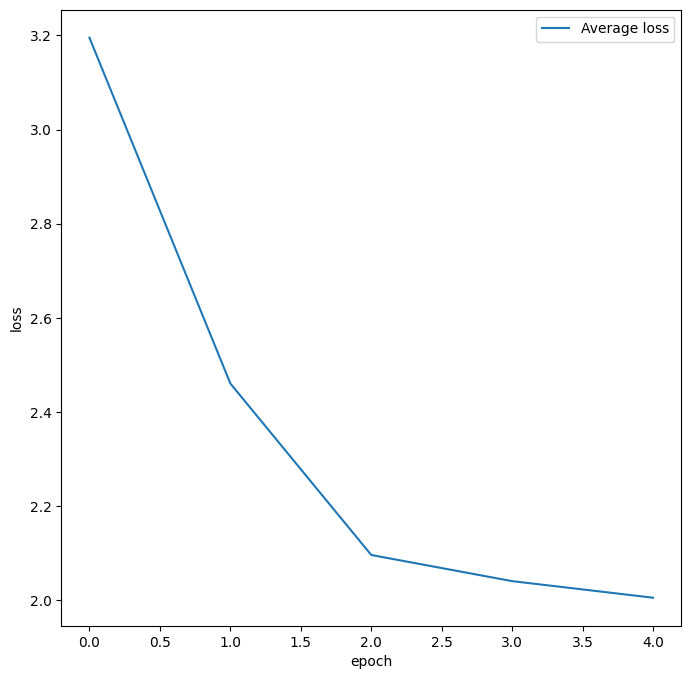

In [12]:
# Train Loop + Save Best + Loss Plot
def train(epoch, model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    with tqdm_notebook(total=len(dataloader), desc=f"Train {epoch+1}") as pbar:
        for batch_idx, samples in enumerate(dataloader):
            src_inputs, trg_outputs = samples

            logits_lm = model(src_inputs, trg_outputs)

            pad = torch.LongTensor(trg_outputs.size(0), 1).fill_(0).to(device)
            preds_id = torch.transpose(logits_lm,1,2)
            labels_lm = torch.cat((trg_outputs[:, 1:], pad), -1)

            optimizer.zero_grad()
            loss = criterion(preds_id, labels_lm)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss += loss.item()
            pbar.update(1)

    return epoch_loss / len(dataloader)

CLIP = 0.5
epoch_ = []
epoch_train_loss = []

torch.backends.cudnn.benchmark = True
best_epoch_loss = float("inf")

for epoch in range(5):
    train_loss = train(epoch, model, dataloader, optimizer, criterion, CLIP)

    if train_loss < best_epoch_loss:
        if not os.path.isdir("checkpoints"):
            os.makedirs("checkpoints")
        best_epoch_loss = train_loss
        torch.save(model.state_dict(), './checkpoints/transformermodel.pt')

    epoch_.append(epoch)
    epoch_train_loss.append(train_loss)
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(epoch_, epoch_train_loss, label='Average loss')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

In [13]:
# Load Best Model + Greedy Decode + Sample Predictions
trained_model = Transformer(
    n_enc_vocab = n_enc_vocab,
    n_dec_vocab = n_dec_vocab,
    n_layers  = n_layers,
    pf_dim      = pf_dim,
    hid_dim     = hid_dim,
    n_heads     = n_heads,
    pe_source   = 512,
    pe_target   = 512,
    dropout     = dropout
).to(device)

trained_model.load_state_dict(torch.load('./checkpoints/transformermodel.pt'))
trained_model.eval()

def evaluate(text):
    text_ids = SRC_tokenizer.texts_to_sequences([text])
    text_ids = pad_sequences(text_ids, maxlen=ENCODER_LEN, padding='post', truncating='post')

    sos_id = TRG_tokenizer.word_index['<sos>']
    eos_id = TRG_tokenizer.word_index['<eos>']

    decoder_input = [sos_id]
    input_tensor  = torch.tensor(text_ids).to(device)
    output_tensor = torch.tensor([decoder_input]).to(device)

    for i in range(DECODER_LEN):
        with torch.no_grad():
            predictions = trained_model(input_tensor, output_tensor)
        predictions = predictions[:, -1:, :]

        predicted_id = torch.argmax(predictions[:,:,3:], axis=-1) + 3

        if int(predicted_id.item()) == eos_id:
            break
        output_tensor = torch.cat((output_tensor, predicted_id), -1)
    return output_tensor

def predict(text):
    prediction = evaluate(text)
    out_list = prediction.tolist()
    out_list[0].pop(0)  # drop <sos>
    output_indexes = out_list[0]
    predicted_sentence = TRG_tokenizer.sequences_to_texts([output_indexes])
    return predicted_sentence

for idx in (11, 21, 31, 41, 51):
    print("Input        :", raw_src[idx])
    print("Prediction   :", predict(raw_src[idx]))
    print("Ground Truth :", raw_trg[idx], "\n")

Input        : he said to her under his breath , i love you .
Prediction   : ['je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je']
Ground Truth : il lui a dit a voix basse je t aime . 

Input        : we were wakened by the whistle of the steam locomotive at dawn .
Prediction   : ['la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la']
Ground Truth : nous avons ete reveilles a l aube par le sifflement d un train . 

Input        : first of all , let me say how glad i am to be here .
Prediction   : ['je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je je']
Ground Truth : tout d abord laissez moi vous dire combien je suis heureux d etre ici . 

Input        : this is a sentence that has the syllable count of a haiku .
Prediction   : ['il la la la la la la la la la la la la la la la la la l